<a href="https://colab.research.google.com/github/SergioTorres-97/Verificacion-de-variables-climatologicas/blob/main/Verificacion_de_datos_climatologicos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**VERIFICACIÓN DE TEMPERATURAS Y HUMEDADES RELATIVAS PARA LAS ESTACIONES DEL ÁREA OPERATIVA 06**

**Autor: SERGIO DAVID TORRES PIRAQUIVE**

**Descripción:**
Este script realiza la lectura, adecuación y visualización de los archivos de precipitación, temeperaturas secas, temperaturas húmedas y humedades relativas de una estación climática principal. Además, identifica valores atípicos en la base de datos y los filtra para su posterior verificación por parte del profesional encargado.

In [1]:
#Se importan las librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import os
import shutil

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Metadatos
rutaArchivo = '/content/TUNGUAVITA'
Estacion = 'TUNGUAVITA'

# #Descomprimir carpeta
# !unrar x -Y '/content/TUNGUAVITA.rar' '/content/TUNGUAVITA'

shutil.unpack_archive(rutaArchivo + '.zip',f'/content/{Estacion}', "zip")


#Se crea la carpeta de guardado
rutaGuardado = f'/content/{Estacion}_resultados'
os.makedirs(rutaGuardado, exist_ok=True)

In [3]:
#Se crean las funciones a utilizar
def AbrirArchivosAQTS(rutaArchivo):
    datos = pd.read_csv(rutaArchivo, header=14)[['Timestamp (UTC-05:00)', 'Value']]
    datos.columns = ['Fecha', 'Valor']
    datos.set_index('Fecha', inplace=True)
    return datos

def filtrarDatos(datos,año_inicial,año_final):
    datos = datos.loc[año_inicial:año_final]
    return datos

def IdentificarNAN3h(datos):
    datos.index = pd.to_datetime(datos.index)
    fechas = pd.date_range(start=datos.index[0], end=datos.index[-1], freq='D')
    horas = [7, 13, 18, 19]
    horas_vector = pd.to_datetime([f"{fecha.date()} {hora}:00:00" for fecha in fechas for hora in horas])
    dfFechas = pd.DataFrame(horas_vector, columns=['Fecha'])

    dfFechas.set_index('Fecha', inplace=True)
    datos_new = pd.concat([dfFechas, datos], axis=1, join='outer')

    hours_18_19 = datos_new.between_time('18:00', '19:00')
    to_drop_19 = hours_18_19[(hours_18_19.index.hour == 19) &
                             (hours_18_19.shift(1)['Valor'].notna())].index

    to_drop_18 = hours_18_19[(hours_18_19.index.hour == 18) &
                             (hours_18_19.shift(-1)['Valor'].notna())].index

    to_drop = to_drop_19.append(to_drop_18)
    df = datos_new.drop(to_drop)

    df_copy = df.copy()
    df_18 = df_copy[df_copy.index.hour == 18]
    df_18.index = df_18.index + pd.DateOffset(hours=1)
    df_combined = pd.concat([df_copy[df_copy.index.hour != 18], df_18])
    df_combined = df_combined.sort_index()
    df = df_combined
    return df

def identificarNAN(datos):
    datos.index = pd.to_datetime(datos.index)
    fecha_inicio = datos.index[0]
    fecha_fin = datos.index[datos.shape[0]-1]
    rango_fechas = pd.date_range(start=fecha_inicio, end=fecha_fin)
    df = pd.DataFrame(rango_fechas, columns=['Fecha'])
    df.set_index('Fecha',inplace = True)

    df_fin = df.join(datos)
    return df_fin

def PromediosMensualesIDEAM(datos,columna, numDatos, estadistico):
    datos = datos.resample('M').agg([estadistico, 'count'])
    datos['sum'] = np.where(datos[columna]['count'] > numDatos, datos[columna][estadistico], np.nan)

    datos = datos[[estadistico]]
    datos.columns = [columna]

    return datos

def Estadisticos(datos, numDatos, estadistico, rutaGuardado,variable):
    datos.columns = ['Valor']
    datos['Mes'] = datos.index.month
    datos['Año'] = datos.index.year

    tabla = pd.pivot(datos, index='Mes', columns='Año', values='Valor')
    est_filaMean, est_filaMed, est_filaMin, est_filaMax, est_filaSum, est_filaQ25, est_fila50, est_fila75 = tabla.mean(), tabla.median(), tabla.min(), tabla.max(),tabla.sum(),tabla.quantile(0.25), tabla.quantile(0.5), tabla.quantile(0.75)

    tabla.loc['Promedio'] = est_filaMean
    tabla.loc['Mediana'] = est_filaMed
    tabla.loc['Mínimo'] = est_filaMin
    tabla.loc['Máxima'] = est_filaMax
    tabla.loc['Suma'] = est_filaSum
    tabla.loc['Q25'] = est_filaQ25
    tabla.loc['Q50'] = est_fila50
    tabla.loc['Q75'] = est_fila75


    est_colMean,est_colMed, est_colMin, est_colMax, est_Q25,est_Q50,estQ75 = tabla.mean(axis = 1),tabla.median(axis = 1), tabla.min(axis = 1), tabla.max(axis = 1),tabla.quantile(0.25,axis = 1),tabla.quantile(0.5,axis = 1),tabla.quantile(0.75,axis = 1)

    tabla['Promedio'] = est_colMean
    tabla['Mediana'] = est_colMed
    tabla['Mínimo'] = est_colMin
    tabla['Máxima'] = est_colMax
    tabla['Q25'] = est_Q25
    tabla['Q50'] = est_Q50
    tabla['Q75'] = estQ75
    tabla = tabla.round(2)

    tabla.to_excel(rutaGuardado + f'/Estadísticos mensuales - {variable}.xlsx')
    return datos

In [4]:
#Rango a filtrar
fecha_ini,fecha_fin,fecha_rep = '1991','2020','2025'
fecha_rep_ini,fecha_rep_fin = '2018','2025'

In [5]:
#Se importan todas las variables de la estación
TMIN_ORI = identificarNAN(filtrarDatos(AbrirArchivosAQTS(rutaArchivo + f'/TMN_CON.csv'),fecha_ini,fecha_rep))
TMX_ORI = identificarNAN(filtrarDatos(AbrirArchivosAQTS(rutaArchivo + f'/TMX_CON.csv'),fecha_ini,fecha_rep))
TSSM_ORI = IdentificarNAN3h(filtrarDatos(AbrirArchivosAQTS(rutaArchivo + f'/TSSM_CON.csv'),fecha_ini,fecha_rep))
THSM_ORI = IdentificarNAN3h(filtrarDatos(AbrirArchivosAQTS(rutaArchivo + f'/THSM_CON.csv'),fecha_ini,fecha_rep))
HREL_ORI = IdentificarNAN3h(filtrarDatos(AbrirArchivosAQTS(rutaArchivo + f'/HR_CAL.csv'),fecha_ini,fecha_rep))
PTPM_ORI = identificarNAN(filtrarDatos(AbrirArchivosAQTS(rutaArchivo + f'/PTPM_CON.csv'),fecha_ini,fecha_rep))

TMIN_ORI.columns = ['TMIN']
TMX_ORI.columns = ['TMX']
TSSM_ORI.columns = ['TSSM']
THSM_ORI.columns = ['THSM']
HREL_ORI.columns = ['HREL']
PTPM_ORI.columns = ['PTPM']

In [6]:
TMIN = TMIN_ORI.loc[fecha_ini:fecha_fin]
TMX = TMX_ORI.loc[fecha_ini:fecha_fin]
TSSM = TSSM_ORI.loc[fecha_ini:fecha_fin]
THSM = THSM_ORI.loc[fecha_ini:fecha_fin]
HREL = HREL_ORI.loc[fecha_ini:fecha_fin]
PTPM = PTPM_ORI.loc[fecha_ini:fecha_fin]

In [7]:
#Se unen los dfs
dfClima = TSSM.join(THSM)
dfClima = dfClima.join(HREL)
dfClima = dfClima.join(TMIN)
dfClima = dfClima.join(TMX)
dfClima = dfClima.join(PTPM)

#Se eliminan duplicados
dfClima = dfClima[~dfClima.index.duplicated(keep='first')]

In [8]:
#Se filtran las variables por hora
TSSM7 = dfClima[dfClima.index.hour == 7]['TSSM']
TSSM13 = dfClima[dfClima.index.hour == 13]['TSSM']
TSSM19 = dfClima[dfClima.index.hour == 19]['TSSM']

THSM7 = dfClima[dfClima.index.hour == 7]['THSM']
THSM13 = dfClima[dfClima.index.hour == 13]['THSM']
THSM19 = dfClima[dfClima.index.hour == 19]['THSM']

HR7 = dfClima[dfClima.index.hour == 7]['HREL']
HR13 = dfClima[dfClima.index.hour == 13]['HREL']
HR19 = dfClima[dfClima.index.hour == 19]['HREL']

In [9]:
#Se añaden las variables al dataframe de clima
dfClima['TSSM7'] = TSSM7
dfClima['TSSM13'] = TSSM13
dfClima['TSSM19'] = TSSM19

dfClima['THSM7'] = THSM7
dfClima['THSM13'] = THSM13
dfClima['THSM19'] = THSM19

dfClima['HR7'] = HR7
dfClima['HR13'] = HR13
dfClima['HR19'] = HR19

#Exportar la matriz generada a excel
dfClimaPer = dfClima.loc['2018':'2023']
dfClimaPer.to_excel(rutaGuardado + f'/Datos_{Estacion}_organizados.xlsx')

In [10]:
#Se hace un promedio diario de las medidas
dfClima = dfClima.resample('D').mean()
dfClima.index = pd.to_datetime(dfClima.index)

In [11]:
#Se eliminan las columnas de TSSM, THSM y HREL
dfClima = dfClima[dfClima.columns[3:]]

In [12]:
#Se crea una columna de meses
dfClima['Mes'] = dfClima.index.month

In [13]:
#Clasificación de la precipitación diaria
def clasificar_precipitacion(mm):
    if mm == 0:
        return 'Sin lluvia'
    elif 0.1 <= mm <= 2.4:
        return 'Lluvia muy ligera'
    elif 2.5 <= mm <= 10:
        return 'Lluvia ligera'
    elif 10.1 <= mm <= 30:
        return 'Lluvia moderada'
    elif 30.1 <= mm <= 60:
        return 'Lluvia fuerte'
    elif 60.1 <= mm <= 100:
        return 'Lluvia muy fuerte'
    elif mm > 100:
        return 'Lluvia torrencial'
    else:
        return 'Sin dato'

dfClima['Clas_Prec'] = dfClima['PTPM'].apply(clasificar_precipitacion)

In [14]:
dfClima.sample(10)

TMIN   TMX  PTPM  TSSM7  TSSM13  TSSM19  THSM7  THSM13  THSM19  \
Fecha                                                                        
2013-08-10   NaN   NaN   NaN    NaN     NaN     NaN    NaN     NaN     NaN   
2010-04-29  10.0  25.2   0.0   12.6    23.4    16.4   12.2    14.8    13.8   
2012-06-07   5.8  22.4   0.4   14.2    21.6    16.4   12.0    14.8    13.4   
2009-04-15  10.8  23.0   0.0   12.8    21.4    15.0   12.4    16.6    13.8   
1991-02-06   5.9  25.1  12.2    9.0    24.0    13.6    8.0    12.6    12.8   
2013-09-28   4.4   NaN   0.0    5.2    23.8    15.6    5.0    14.0    12.8   
2000-10-02   5.7  20.6   1.7    9.8    19.0    11.0    9.8    12.6     NaN   
2016-03-15  10.0  24.0   0.0   12.2    23.0    16.8   11.6    15.6    12.4   
2020-01-19   3.4  24.8   0.0    6.0    22.6    15.0    6.0    14.2    12.2   
2008-12-08  10.0  20.2   0.0   13.8    19.0    15.0   12.8    15.6    14.0   

              HR7  HR13  HR19  Mes          Clas_Prec  
Fecha                                                  
2013-08-10    NaN   NaN   NaN    8           Sin dato  
2010-04-29   96.0  40.0  76.0    4         Sin lluvia  
2012-06-07   78.0  49.0  73.0    6  Lluvia muy ligera  
2009-04-15   96.0  63.0  88.0    4         Sin lluvia  
1991-02-06   88.0  26.0  92.0    2    Lluvia moderada  
2013-09-28   97.0  34.0  74.0    9         Sin lluvia  
2000-10-02  100.0  49.0   NaN   10  Lluvia muy ligera  
2016-03-15   94.0  47.0  61.0    3         Sin lluvia  
2020-01-19  100.0  40.0  73.0    1         Sin lluvia  
2008-12-08   90.0  71.0  90.0   12         Sin lluvia

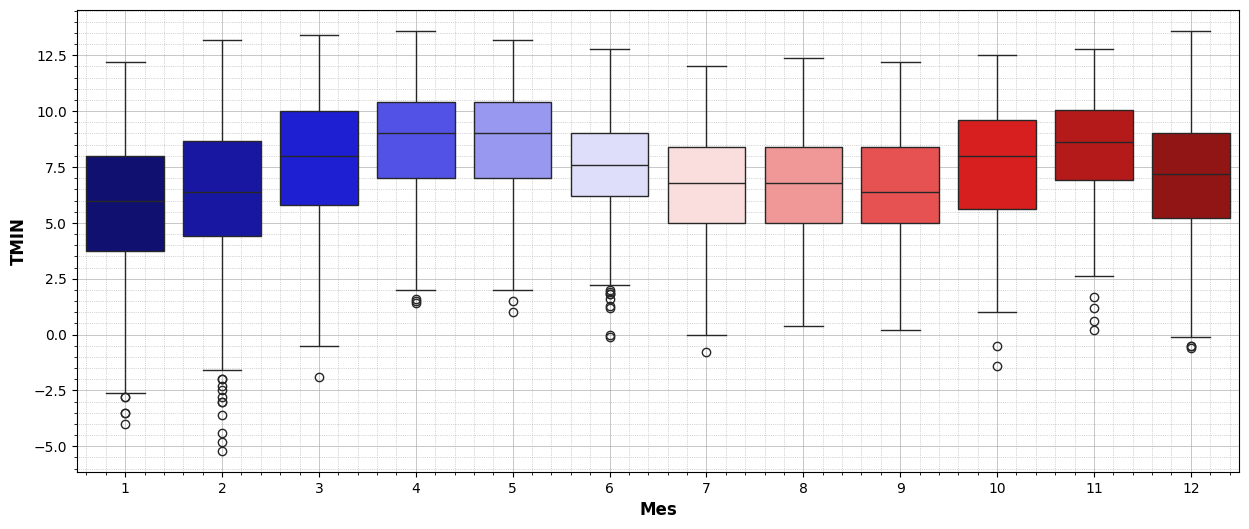

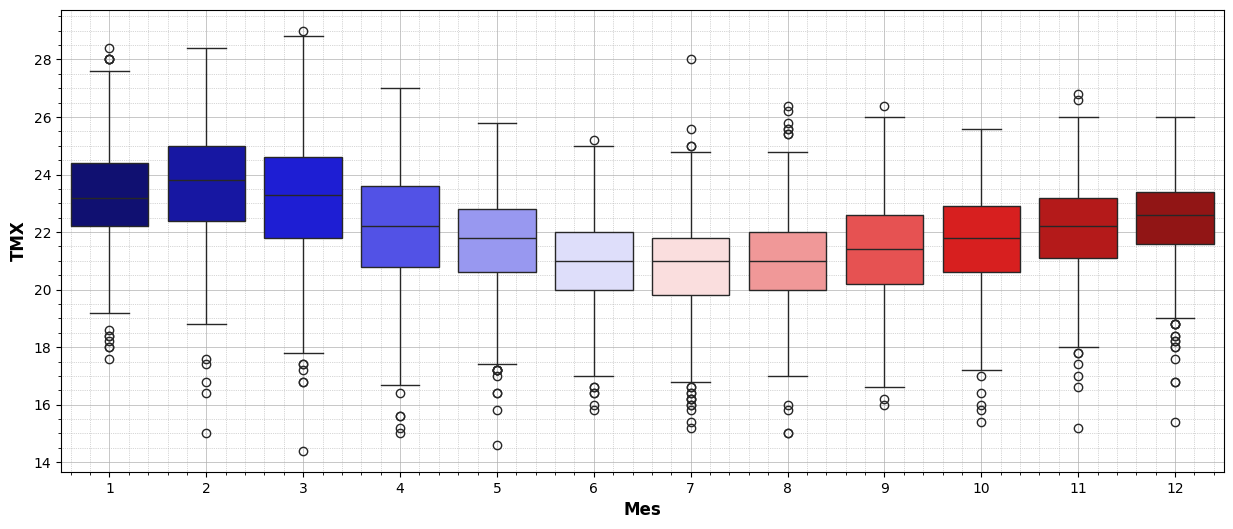

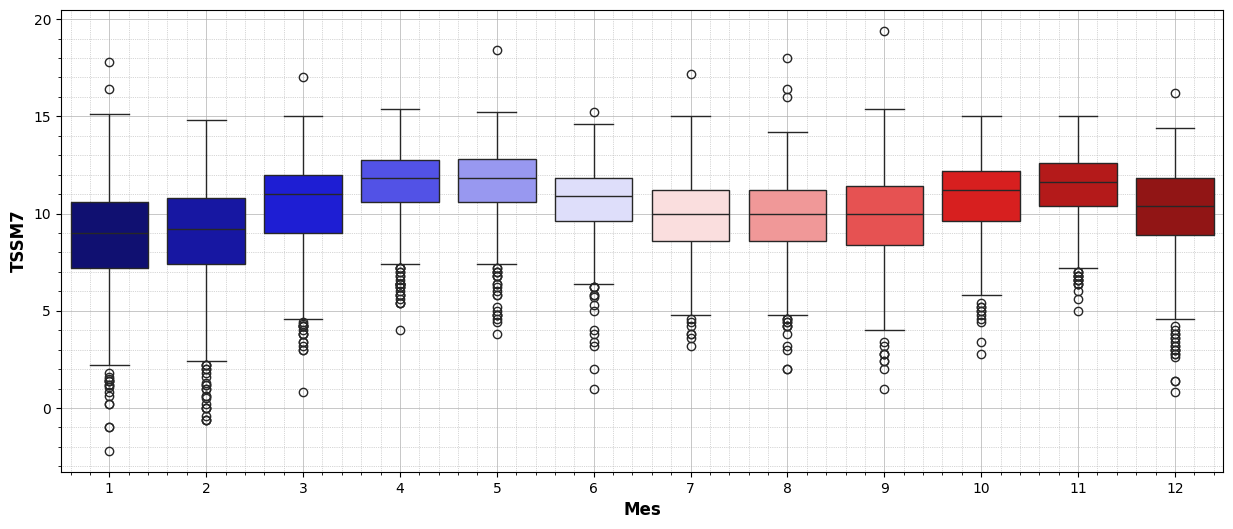

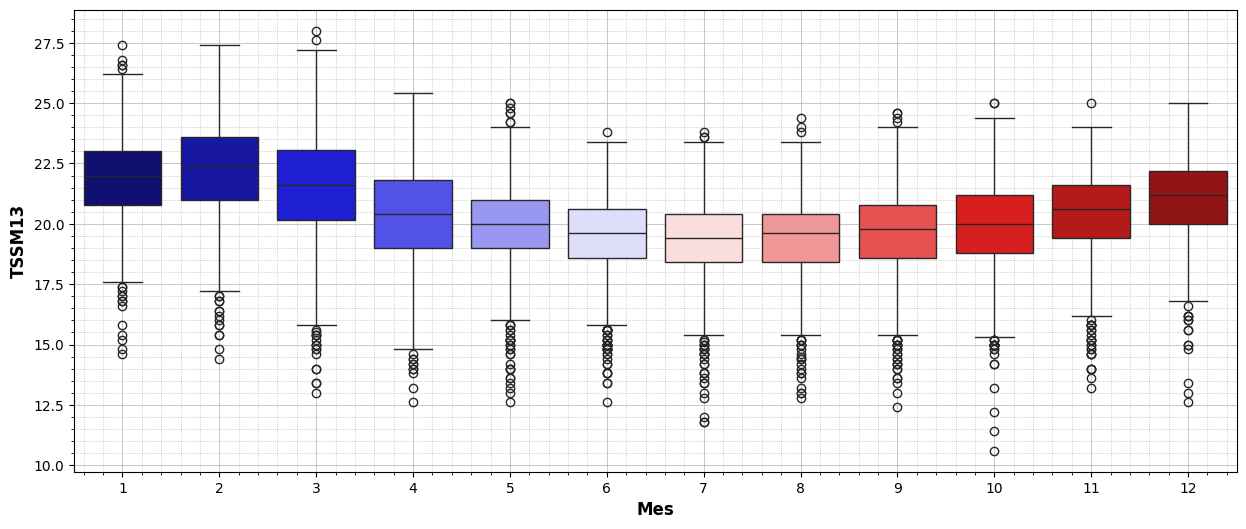

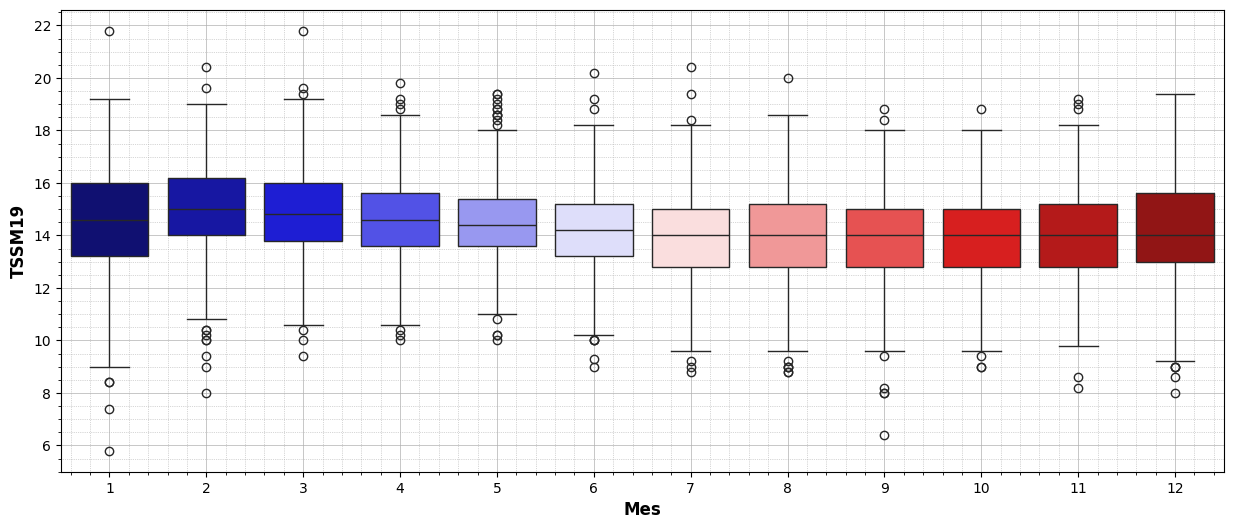

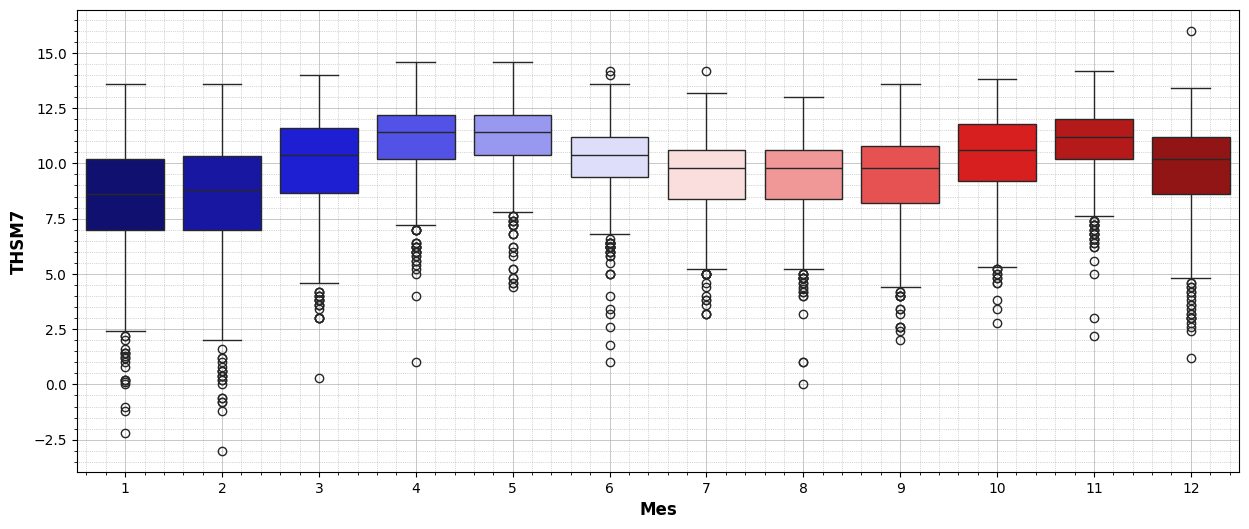

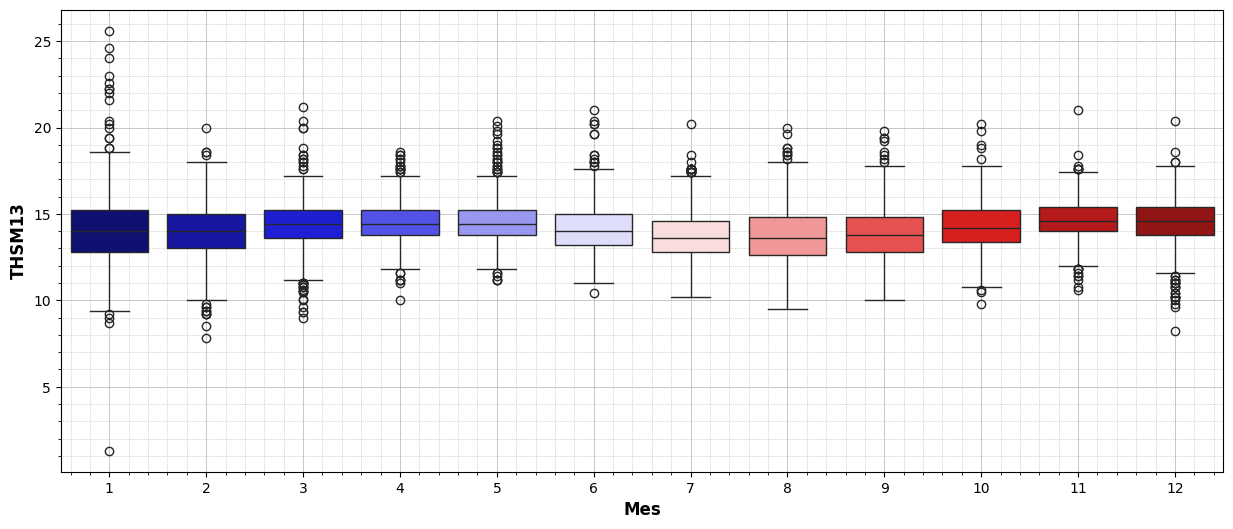

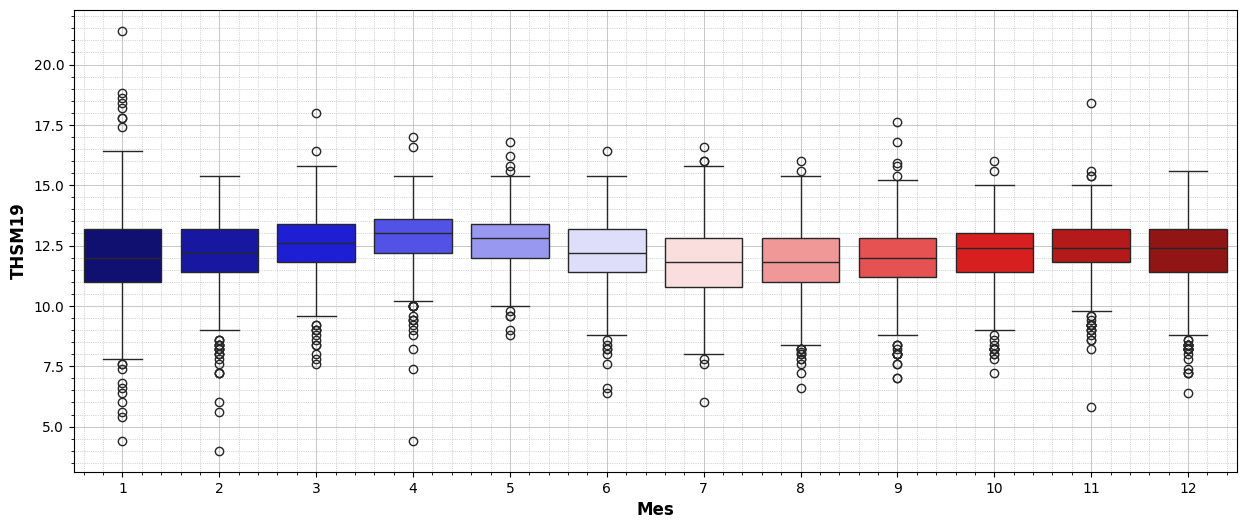

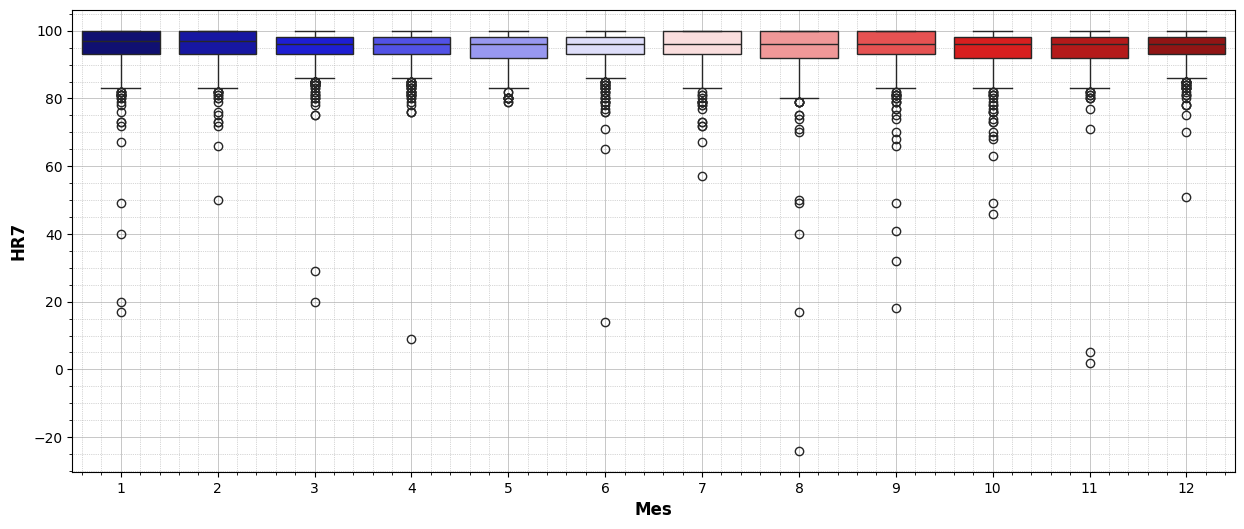

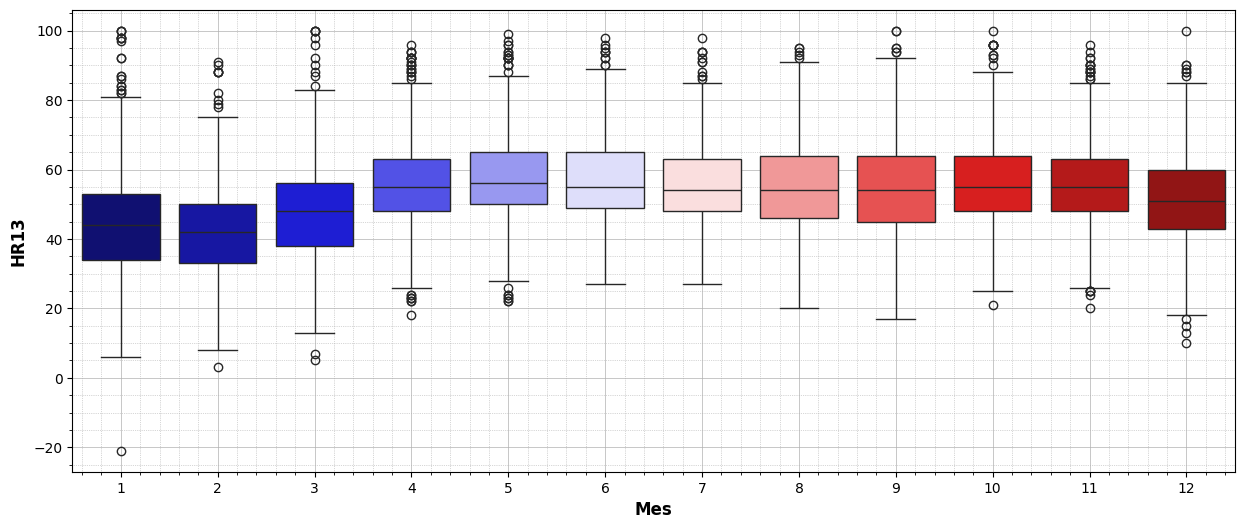

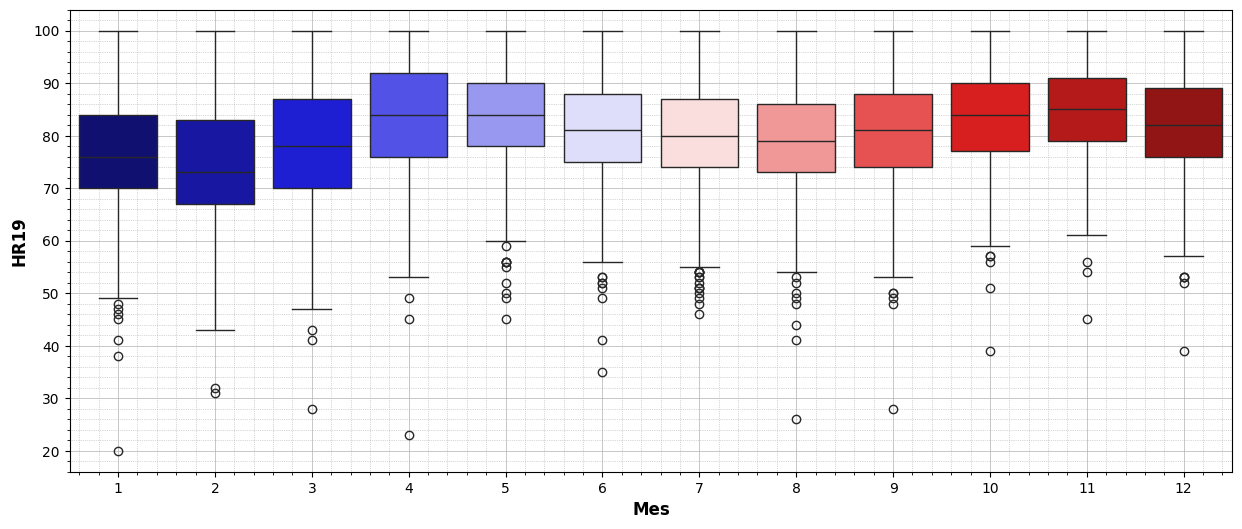

In [15]:
#Boxplots a escala diaria
columna = ['TMIN', 'TMX', 'TSSM7', 'TSSM13','TSSM19',
           'THSM7', 'THSM13', 'THSM19', 'HR7', 'HR13', 'HR19']

for i in range(0,len(columna)):
  plt.figure(figsize=(15, 6))
  sbn.boxplot(data=dfClima, x='Mes', y=columna[i], palette='seismic')
  plt.xlabel('Mes', fontsize=12, fontweight='bold')
  plt.ylabel(columna[i], fontsize=12, fontweight='bold')

  plt.minorticks_on()
  plt.grid(which='major', linestyle='-', linewidth='0.5',zorder = 1)
  plt.grid(which='minor', linestyle=':', linewidth='0.5',zorder = 1)

  plt.savefig(rutaGuardado + f'/Boxplot diario {columna[i]}.png')

In [16]:
#Medianas de las variables
df_numericas = dfClima.select_dtypes(include=['number'])
df_numericas = df_numericas.drop(columns=['PTPM'])
df_numericas.groupby('Mes').median()

TMIN   TMX  TSSM7  TSSM13  TSSM19  THSM7  THSM13  THSM19   HR7  HR13  \
Mes                                                                         
1     6.0  23.2    9.0    22.0    14.6    8.6    14.0    12.0  97.0  44.0   
2     6.4  23.8    9.2    22.4    15.0    8.8    14.0    12.2  97.0  42.0   
3     8.0  23.3   11.0    21.6    14.8   10.4    14.4    12.6  96.0  48.0   
4     9.0  22.2   11.8    20.4    14.6   11.4    14.4    13.0  96.0  55.0   
5     9.0  21.8   11.8    20.0    14.4   11.4    14.4    12.8  96.0  56.0   
6     7.6  21.0   10.9    19.6    14.2   10.4    14.0    12.2  96.0  55.0   
7     6.8  21.0   10.0    19.4    14.0    9.8    13.6    11.8  96.0  54.0   
8     6.8  21.0   10.0    19.6    14.0    9.8    13.6    11.8  96.0  54.0   
9     6.4  21.4   10.0    19.8    14.0    9.8    13.8    12.0  96.0  54.0   
10    8.0  21.8   11.2    20.0    14.0   10.6    14.2    12.4  96.0  55.0   
11    8.6  22.2   11.6    20.6    14.0   11.2    14.6    12.4  96.0  55.0   
12    7.2  22.6   10.4    21.2    14.0   10.2    14.6    12.4  96.0  51.0   

     HR19  
Mes        
1    76.0  
2    73.0  
3    78.0  
4    84.0  
5    84.0  
6    81.0  
7    80.0  
8    79.0  
9    81.0  
10   84.0  
11   85.0  
12   82.0

In [17]:
#Cuantil 25% de los datos
df_numericas.groupby('Mes').quantile(0.25)

TMIN   TMX  TSSM7  TSSM13  TSSM19  THSM7  THSM13  THSM19   HR7  HR13  \
Mes                                                                         
1    3.75  22.2    7.2   20.80    13.2   7.00    12.8    11.0  93.0  34.0   
2    4.40  22.4    7.4   21.00    14.0   7.00    13.0    11.4  93.0  33.0   
3    5.80  21.8    9.0   20.15    13.8   8.65    13.6    11.8  93.0  38.0   
4    7.00  20.8   10.6   19.00    13.6  10.20    13.8    12.2  93.0  48.0   
5    7.00  20.6   10.6   19.00    13.6  10.40    13.8    12.0  92.0  50.0   
6    6.20  20.0    9.6   18.60    13.2   9.40    13.2    11.4  93.0  49.0   
7    5.00  19.8    8.6   18.40    12.8   8.40    12.8    10.8  93.0  48.0   
8    5.00  20.0    8.6   18.40    12.8   8.40    12.6    11.0  92.0  46.0   
9    5.00  20.2    8.4   18.60    12.8   8.20    12.8    11.2  93.0  45.0   
10   5.60  20.6    9.6   18.80    12.8   9.20    13.4    11.4  92.0  48.0   
11   6.90  21.1   10.4   19.40    12.8  10.20    14.0    11.8  92.0  48.0   
12   5.20  21.6    8.9   20.00    13.0   8.60    13.8    11.4  93.0  43.0   

     HR19  
Mes        
1    70.0  
2    67.0  
3    70.0  
4    76.0  
5    78.0  
6    75.0  
7    74.0  
8    73.0  
9    74.0  
10   77.0  
11   79.0  
12   76.0

In [18]:
#Cuantil 75% de los datos
df_numericas.groupby('Mes').quantile(0.75)

TMIN   TMX  TSSM7  TSSM13  TSSM19  THSM7  THSM13  THSM19    HR7  HR13  \
Mes                                                                           
1     8.00  24.4  10.60   23.00    16.0  10.20    15.2    13.2  100.0  53.0   
2     8.65  25.0  10.80   23.60    16.2  10.35    15.0    13.2  100.0  50.0   
3    10.00  24.6  12.00   23.05    16.0  11.60    15.2    13.4   98.0  56.0   
4    10.40  23.6  12.75   21.80    15.6  12.20    15.2    13.6   98.0  63.0   
5    10.40  22.8  12.80   21.00    15.4  12.20    15.2    13.4   98.0  65.0   
6     9.00  22.0  11.80   20.60    15.2  11.20    15.0    13.2   98.0  65.0   
7     8.40  21.8  11.20   20.40    15.0  10.60    14.6    12.8  100.0  63.0   
8     8.40  22.0  11.20   20.40    15.2  10.60    14.8    12.8  100.0  64.0   
9     8.40  22.6  11.40   20.80    15.0  10.80    14.8    12.8  100.0  64.0   
10    9.60  22.9  12.20   21.20    15.0  11.80    15.2    13.0   98.0  64.0   
11   10.05  23.2  12.60   21.60    15.2  12.00    15.4    13.2   98.0  63.0   
12    9.00  23.4  11.80   22.20    15.6  11.20    15.4    13.2   98.0  60.0   

     HR19  
Mes        
1    84.0  
2    83.0  
3    87.0  
4    92.0  
5    90.0  
6    88.0  
7    87.0  
8    86.0  
9    88.0  
10   90.0  
11   91.0  
12   89.0

**Series Temporales**

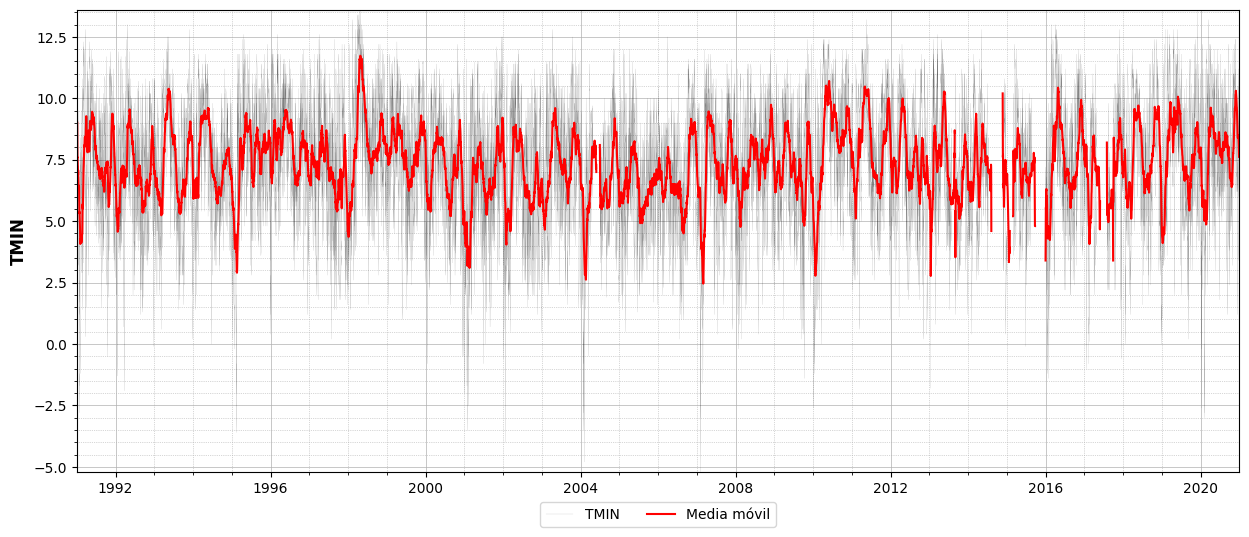

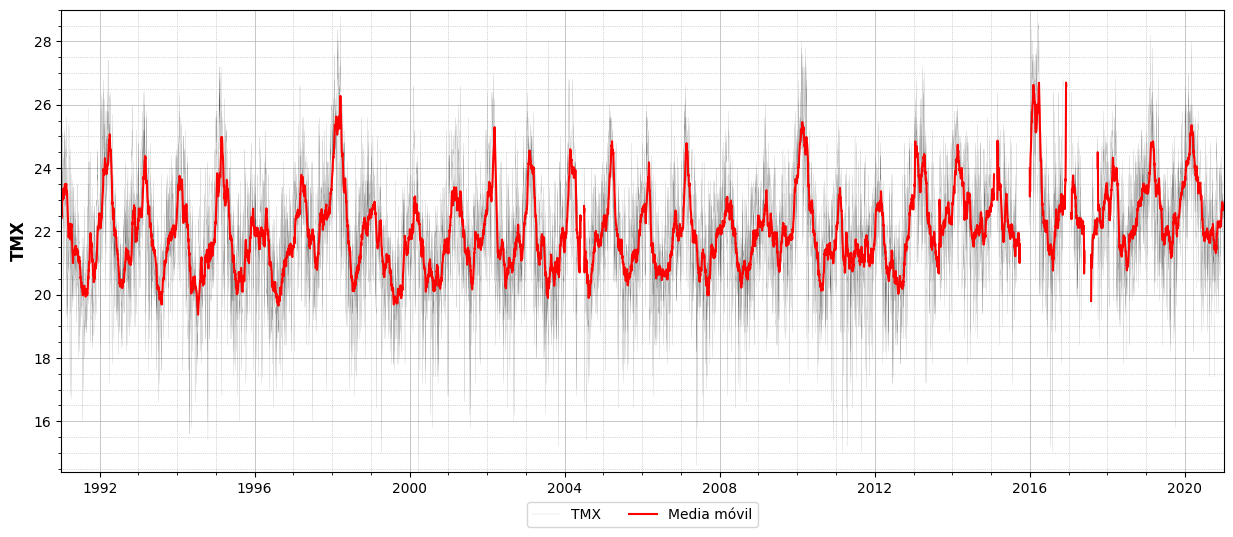

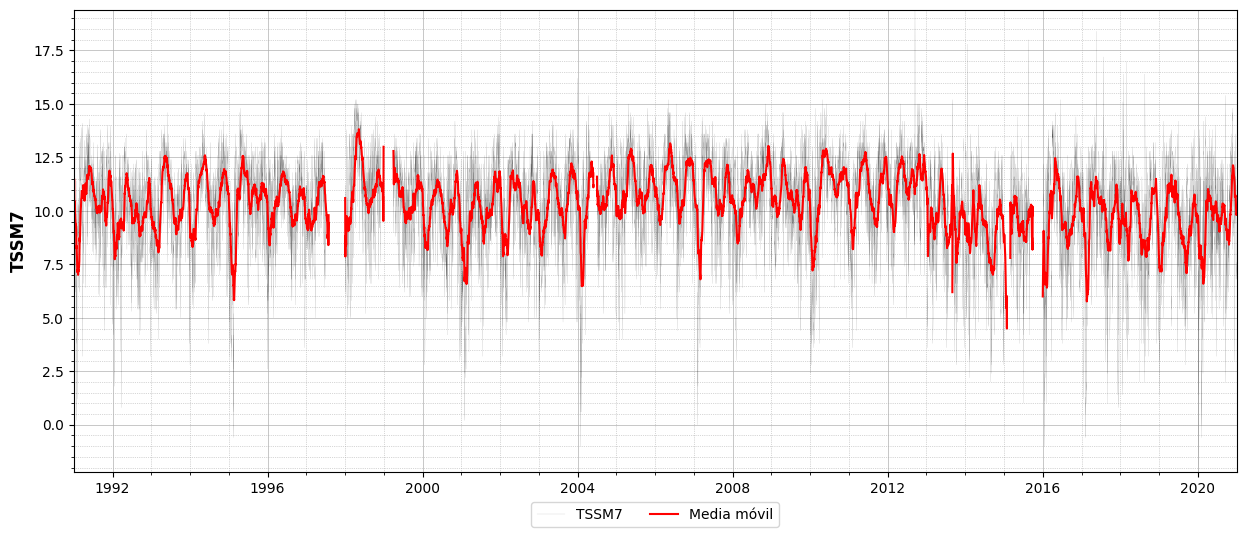

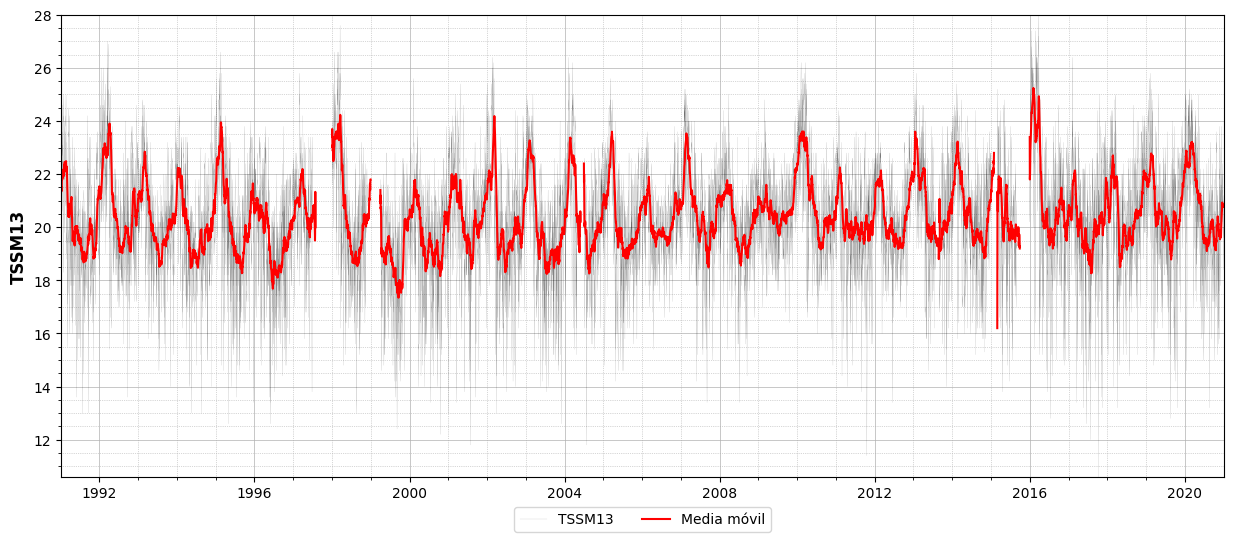

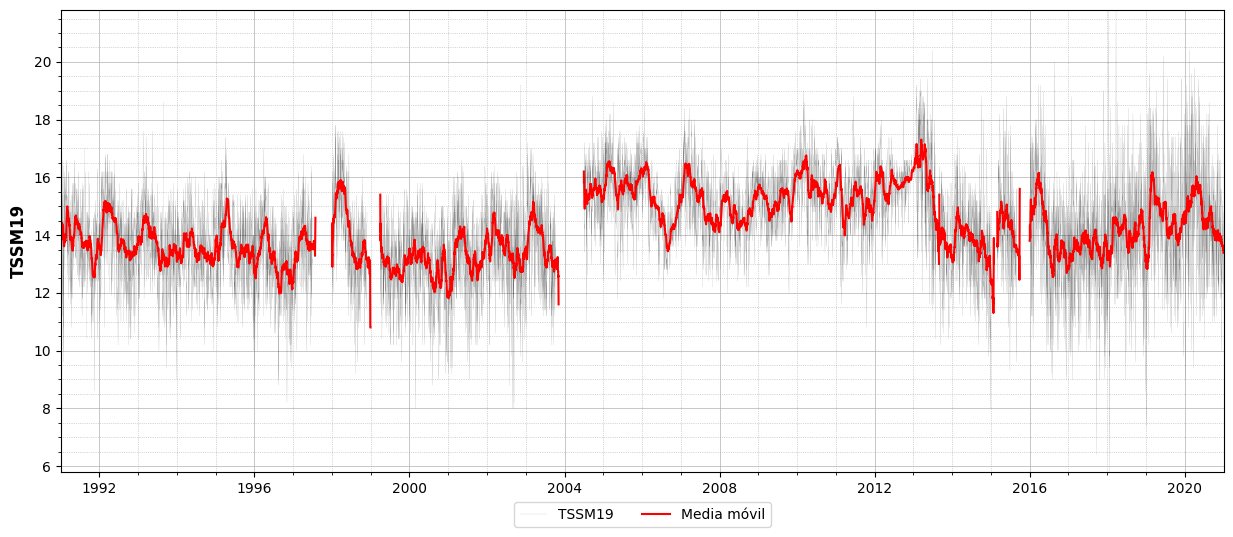

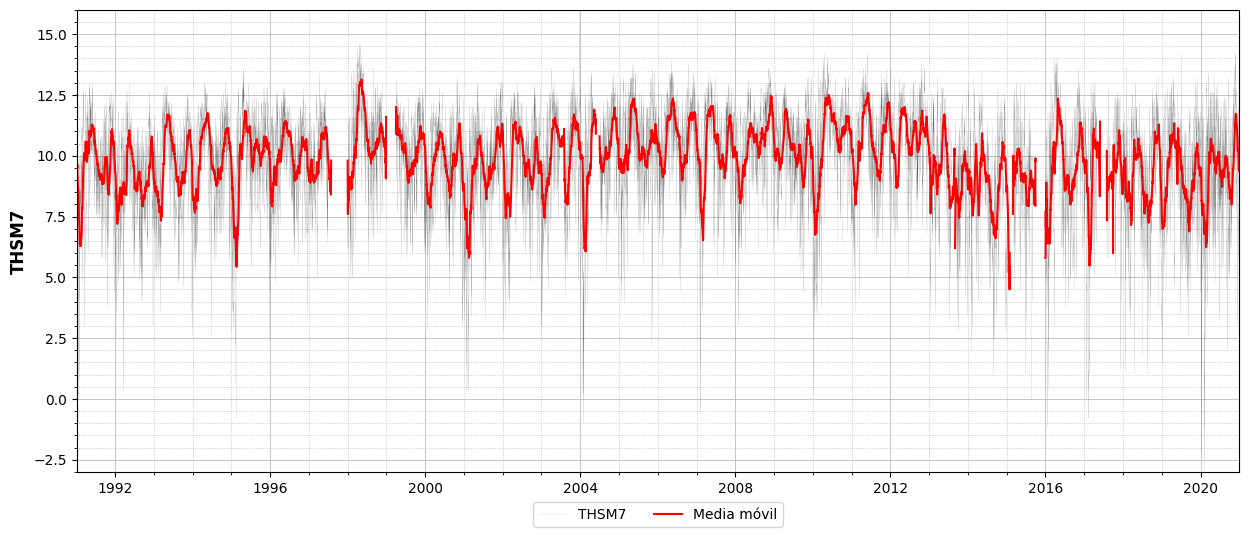

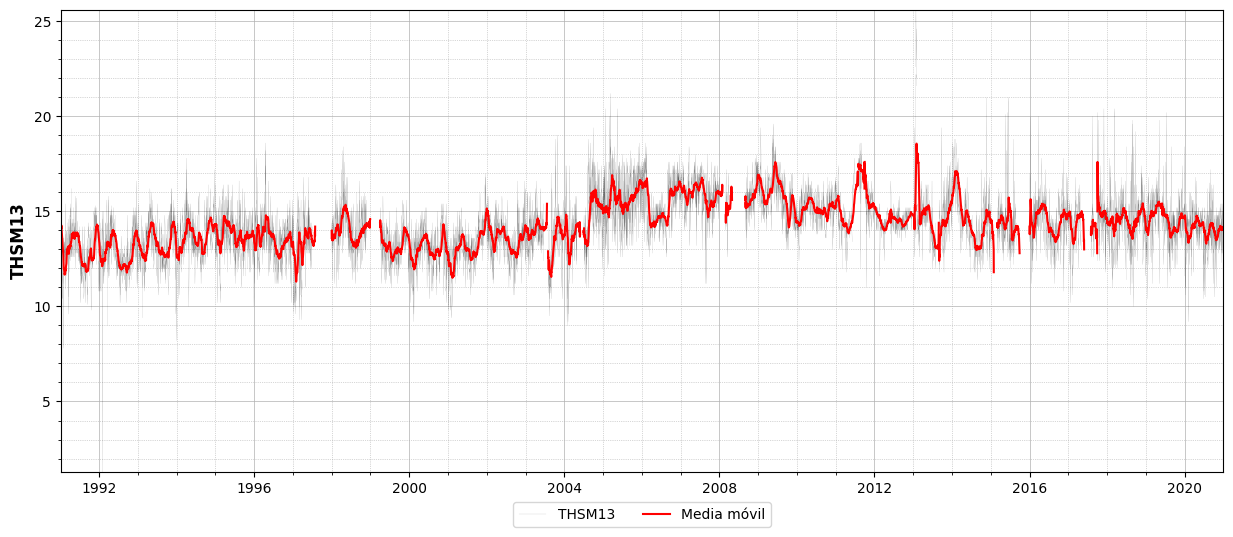

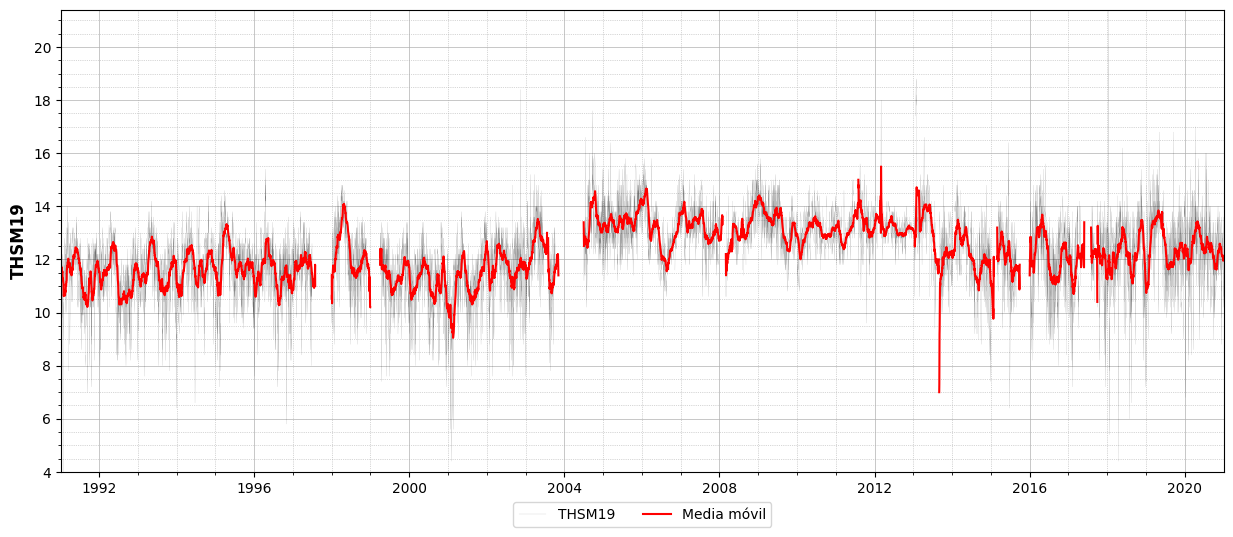

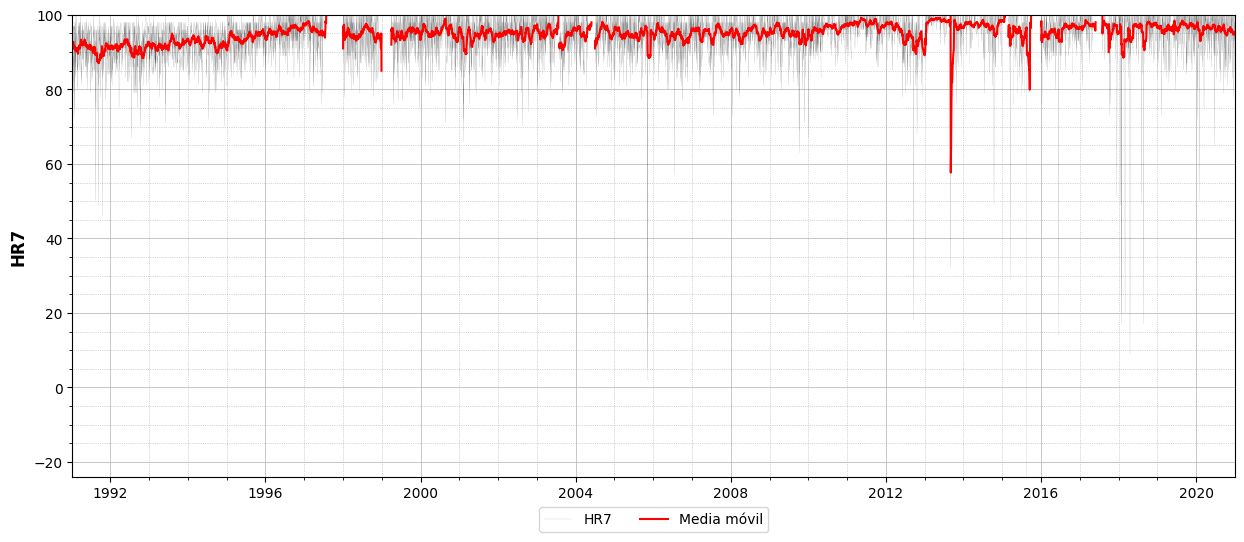

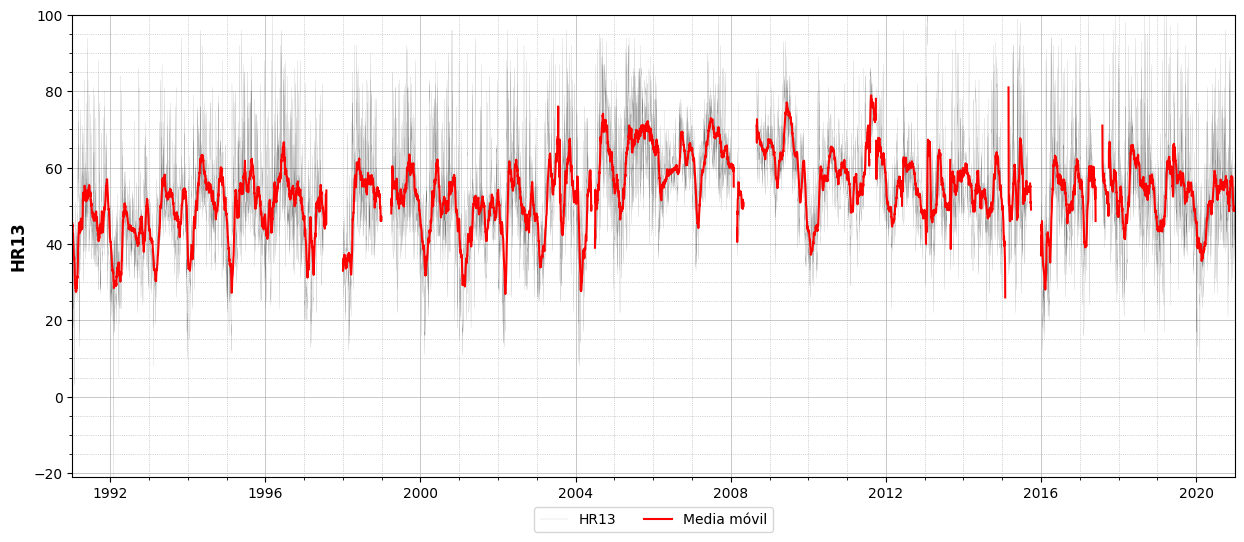

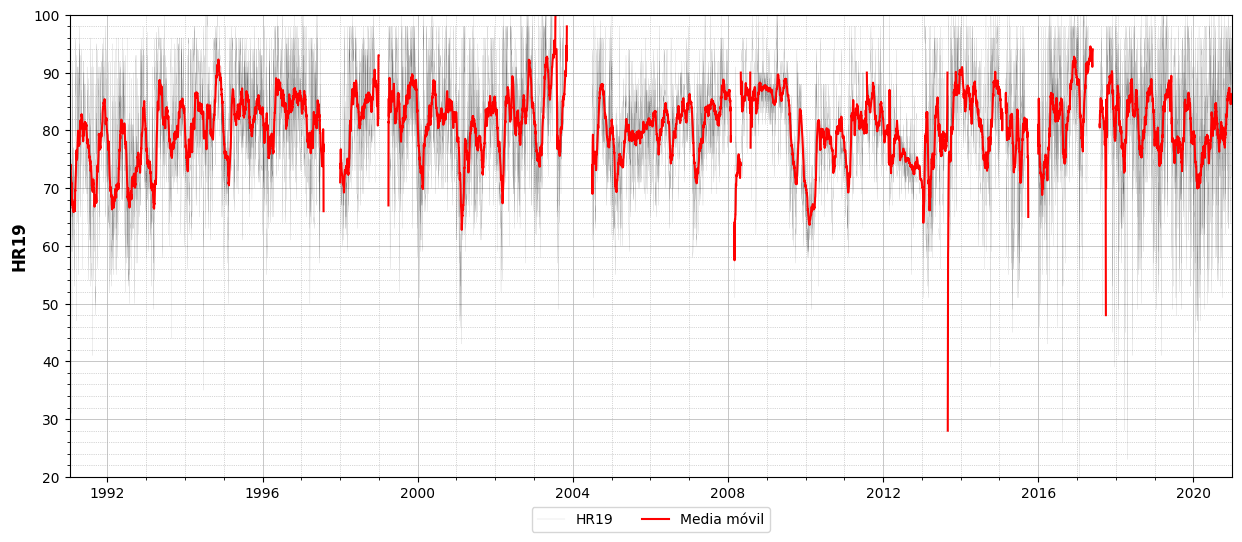

In [19]:
for i in range(0,len(columna)):
  dfClima[f'{columna[i]}_mm'] = dfClima[columna[i]].rolling(window=30, min_periods=1).mean()

  plt.figure(figsize=(15, 6))
  plt.plot(dfClima.index,dfClima[columna[i]],color = 'black',linewidth = 0.05, label = columna[i])
  plt.plot(dfClima.index, dfClima[f'{columna[i]}_mm'], color="red", label = 'Media móvil')

  plt.ylabel(columna[i], fontsize=12, fontweight='bold')
  plt.xlim(dfClima.index[i],dfClima.index[-1])
  plt.ylim(dfClima[columna[i]].min(),dfClima[columna[i]].max())

  plt.minorticks_on()
  plt.grid(which='major', linestyle='-', linewidth='0.5',zorder = 1)
  plt.grid(which='minor', linestyle=':', linewidth='0.5',zorder = 1)

  plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=True)

  plt.savefig(rutaGuardado + f'/Serie temporal {columna[i]}.png')
  dfClima = dfClima.drop(columns=[f'{columna[i]}_mm'])

**Validaciones básicas**

In [20]:
#Datos faltantes
Faltantes = dfClima[dfClima.isna().any(axis=1)].loc[fecha_rep_ini:fecha_rep_fin]
Faltantes['Observaciones'] = 'Dato faltante'
Faltantes

TMIN   TMX  PTPM  TSSM7  TSSM13  TSSM19  THSM7  THSM13  THSM19  \
Fecha                                                                        
2018-01-02   8.0  18.0  10.6    9.6    15.4    11.4    NaN    14.6    11.0   
2018-02-12   8.0   NaN   0.6   11.0    24.0    12.8   10.2    15.4    12.2   
2018-02-13   6.2  24.8   0.0    7.8    23.6    14.6    NaN    15.8    12.8   
2018-02-17  10.0  24.6   2.1   12.4    22.0    13.4   12.0     NaN    13.0   
2018-02-18   7.0  23.4   0.0    9.6    22.4    15.0    NaN    15.6    12.0   
...          ...   ...   ...    ...     ...     ...    ...     ...     ...   
2020-05-15   9.0   NaN   0.6    9.8    21.2    14.6    9.2    14.6    13.4   
2020-05-16  11.2   NaN   0.0   12.2    21.0    18.6   12.0    14.2    13.2   
2020-05-17   7.4   NaN   0.0    8.0    19.4    18.8    7.6    13.2    12.6   
2020-10-05  11.4   NaN   0.7   12.2    18.0     NaN   11.6    13.4     NaN   
2020-12-24   9.4  22.4   0.0   11.0    21.2     NaN   10.6    15.4     NaN   

             HR7  HR13  HR19  Mes          Clas_Prec  Observaciones  
Fecha                                                                
2018-01-02   NaN  92.0  96.0    1    Lluvia moderada  Dato faltante  
2018-02-12  91.0  41.0  94.0    2  Lluvia muy ligera  Dato faltante  
2018-02-13   NaN  45.0  82.0    2         Sin lluvia  Dato faltante  
2018-02-17  96.0   NaN  96.0    2  Lluvia muy ligera  Dato faltante  
2018-02-18   NaN  50.0  72.0    2         Sin lluvia  Dato faltante  
...          ...   ...   ...  ...                ...            ...  
2020-05-15  93.0  50.0  88.0    5  Lluvia muy ligera  Dato faltante  
2020-05-16  98.0  48.0  55.0    5         Sin lluvia  Dato faltante  
2020-05-17  95.0  51.0  50.0    5         Sin lluvia  Dato faltante  
2020-10-05  94.0  61.0   NaN   10  Lluvia muy ligera  Dato faltante  
2020-12-24  96.0  55.0   NaN   12         Sin lluvia  Dato faltante  

[104 rows x 15 columns]

In [21]:
#Se identifica si algún dato de TMIN es superior a la TSSM de las 7
AtipMin = dfClima.loc[dfClima['TMIN']+0.5>=dfClima['TSSM7']]
AtipMin = AtipMin.loc[AtipMin['HR7'] < 90].loc[fecha_rep_ini:fecha_rep_fin]
AtipMin['Observaciones'] = 'TSSM7 < TMIN'
AtipMin

TMIN   TMX  PTPM  TSSM7  TSSM13  TSSM19  THSM7  THSM13  THSM19  \
Fecha                                                                        
2018-04-26  10.8  20.4   2.6   11.0    18.4    14.8   10.0    13.2    14.2   
2019-02-27  12.0  22.0   1.3   12.2    20.8    13.4   11.0    14.8    12.2   
2019-04-21  12.8  23.0   7.7   12.8    20.4    13.0   11.6    16.6    13.0   
2019-10-02   7.0  22.4   1.2    7.4    22.0    17.4    6.2    14.0    13.4   
2020-02-17   4.6  25.8   0.0    4.8    25.0    20.4    4.0    13.4    11.2   
2020-09-24   8.2  22.8   2.5    8.4    20.0    12.6    7.2    12.0    11.4   
2020-10-18   8.4  21.2   0.0    8.8    20.2    14.6    7.2    14.8    12.0   

             HR7  HR13   HR19  Mes          Clas_Prec Observaciones  
Fecha                                                                
2018-04-26  89.0  57.0   94.0    4      Lluvia ligera  TSSM7 < TMIN  
2019-02-27  87.0  54.0   88.0    2  Lluvia muy ligera  TSSM7 < TMIN  
2019-04-21  87.0  69.0  100.0    4      Lluvia ligera  TSSM7 < TMIN  
2019-10-02  85.0  42.0   65.0   10  Lluvia muy ligera  TSSM7 < TMIN  
2020-02-17  89.0  26.0   32.0    2         Sin lluvia  TSSM7 < TMIN  
2020-09-24  85.0  39.0   87.0    9      Lluvia ligera  TSSM7 < TMIN  
2020-10-18  81.0  57.0   75.0   10         Sin lluvia  TSSM7 < TMIN

In [22]:
#Se identifica si algún dato de TMAX es inferior a la TSSM de las 13
AtipMax = dfClima.loc[dfClima['TMX']-0.5 <= dfClima['TSSM13']]
AtipMax = AtipMax.loc[AtipMax['HR13'] > 40].loc[fecha_rep_ini:fecha_rep_fin]
AtipMax['Observaciones'] = 'TSSM13 > TMX'
AtipMax

TMIN   TMX  PTPM  TSSM7  TSSM13  TSSM19  THSM7  THSM13  THSM19  \
Fecha                                                                        
2018-02-01   5.2  24.6   0.0    7.2    24.2    14.8    7.2    17.4    10.4   
2018-05-12   8.0  22.4  16.5    9.4    22.0    12.6    9.2    16.8     NaN   
2018-05-20  10.2  21.6   0.9   11.4    21.2    15.4   11.2    14.2    13.2   
2018-06-16   9.2  20.2   4.0   11.8    20.0    13.2   10.8    15.0    12.6   
2018-06-27   4.2  20.6   3.3    5.8    20.4    14.4    5.8    14.6    13.8   
2018-06-28   7.8  20.2   1.2   10.0    19.8    11.6   10.0    14.8    11.4   
2018-07-20   4.2  22.8   0.0    7.2    22.6    17.0    NaN    15.4    12.0   
2018-08-08   7.4  21.8   0.5    8.0    21.4    15.8    8.0    14.4    12.4   
2018-08-29   6.2  23.0   3.4    6.6    22.6    14.8    NaN    19.6    12.2   
2018-09-15  11.4  20.4   7.3   11.4    20.0    16.4   11.0    16.4    11.8   
2018-09-19   6.0  21.3   0.0    7.0    20.8    16.4    7.0    13.6    12.4   
2018-09-25   5.4  21.0   0.0    7.0    20.8    15.8    6.8    14.2    12.0   
2018-10-01   4.8  21.6  26.0    6.8    21.4    12.8    NaN    14.6    12.4   
2018-10-25  11.6  20.2   1.9   12.4    19.8    15.4   12.4    15.4    14.2   
2018-12-09   4.8  24.0   0.0    7.8    23.8    10.2    6.8    16.0     9.8   
2018-12-13   6.0  23.0   1.2    9.4    22.8    16.0    9.2    14.4    13.8   
2019-02-05   7.0  22.6   1.5    8.0    22.6    14.4    NaN    15.2    13.8   
2019-05-05  10.4  20.6   2.5   10.8    20.2    17.4   10.8    19.8    13.4   
2019-06-06   7.2  20.6   1.2    7.8    20.4    13.8    7.8    14.8    13.0   
2019-07-25   4.2  24.0   0.0    6.4    23.6    13.8    5.8    15.6    11.0   
2019-09-01   9.6  21.2   0.0   10.4    20.8    16.8   10.2    14.4    13.2   
2019-09-06   6.2  23.0   0.0   10.2    22.6    13.6    9.8    14.8    10.4   
2019-09-09   4.8  21.0   0.0    6.4    20.6    16.6    6.4    14.0    13.8   
2019-10-02   7.0  22.4   1.2    7.4    22.0    17.4    6.2    14.0    13.4   
2019-10-13   8.6  19.6   1.2    9.2    19.4    16.2    9.2    13.4    12.6   
2019-10-27   7.8  21.6   5.0   10.2    21.4    15.2    9.8    15.0    13.6   
2019-11-05   8.4  22.4   0.0   11.0    22.2    11.0   10.4    16.2    10.0   
2019-12-11   9.0  24.2   0.0   10.2    24.0    14.4    9.2    17.4    12.0   
2019-12-15  11.4  22.0   3.2   12.0    21.6    13.6   11.0    14.0    13.2   
2019-12-24   5.6  23.4   0.0    7.0    23.0     NaN    7.0    14.8     NaN   
2020-05-05   9.0  20.4   0.0   10.6    20.0    16.6   10.2    14.2    13.4   
2020-06-12  12.0  21.0   3.2   14.0    20.7    13.2   13.0    14.8    12.4   
2020-06-22   8.4  21.8   0.4   11.0    21.6    17.4   10.0    14.6    11.8   
2020-07-04  11.8  21.0   0.5   12.0    21.0    10.4   11.6    14.6    10.4   
2020-07-09   8.4  20.8   0.0    9.6    20.4    14.8    9.6    13.2    13.6   
2020-08-05   7.4  20.4   0.0    9.6    20.0    14.2    9.6    14.0    11.8   
2020-08-12  10.6  22.6   0.0   12.4    22.6    15.4   11.6    14.8    12.6   
2020-08-14   9.2  20.5   0.0   10.8    20.0    15.6   10.0    13.8    10.5   
2020-08-15   8.2  21.4   9.4   10.0    21.0    17.8    9.8    13.0    12.6   
2020-08-22  11.2  19.4   7.7   12.4    19.2    12.6   12.4    14.4    12.6   
2020-08-23   9.0  20.0   1.0   10.2    19.5    15.4   10.2    16.5    13.8   
2020-09-03  10.0  20.4   0.0   12.2    20.0    13.6   12.0    14.0    12.0   
2020-09-17  10.0  21.4  12.4   11.2    21.4    14.4   11.0    15.2    12.6   
2020-10-16   8.0  20.4   0.0    9.4    20.4    15.2    9.4    13.8    13.4   
2020-10-26   9.0  23.6   0.8   11.0    23.2    14.8   10.8    15.2    11.4   
2020-11-05  10.8  21.2   1.6   13.0    21.0    13.0   12.2    14.6    12.4   

              HR7  HR13   HR19  Mes          Clas_Prec Observaciones  
Fecha                                                                 
2018-02-01  100.0  52.0   59.0    2         Sin lluvia  TSSM13 > TMX  
2018-05-12   98.0  60.0    NaN    5    Lluvia moderada

In [23]:
#Se identifican los HR a las 13 superiores al 70% sin lluvia
AtipHrel13 = dfClima.loc[dfClima['HR13'] > 70].loc[fecha_rep_ini:fecha_rep_fin]
AtipHrel13 = AtipHrel13.loc[AtipHrel13['Clas_Prec'] == 'Sin lluvia']
AtipHrel13 = AtipHrel13.loc[fecha_rep_ini:fecha_rep_fin]
AtipHrel13['Observaciones'] = 'HR13 > 70% sin lluvia'
AtipHrel13

TMIN   TMX  PTPM  TSSM7  TSSM13  TSSM19  THSM7  THSM13  THSM19  \
Fecha                                                                        
2018-03-09   3.4  25.2   0.0    5.8    23.6    14.0    NaN    20.4    11.8   
2018-03-10   3.4  24.8   0.0    7.2    23.2    14.6    7.2    20.0    11.2   
2018-04-18   9.0  20.8   0.0   10.0    17.8    13.4    1.0    15.0    12.2   
2018-05-02  10.2  23.0   0.0   11.4    18.4    12.0    NaN    15.0    11.0   
2018-07-26   6.8  23.4   0.0    8.6    17.2    16.3    8.0    14.8    12.4   
2018-08-07   5.4  22.6   0.0    8.2    17.4    11.0    7.8    16.6    10.0   
2018-08-19   5.4  22.8   0.0    5.4    20.4    11.4    5.2    18.0    10.0   
2018-09-01   5.0  24.2   0.0    7.2    19.8    16.6    7.2    19.8    13.2   
2019-03-08   8.0  24.2   0.0    8.4    14.8    12.6    NaN    14.8    12.6   
2019-06-14  10.0  23.0   0.0   11.4    20.2    19.2   10.8    17.4    13.4   
2019-07-14   9.8  22.0   0.0   11.6    20.4    13.0   11.0    20.2    12.0   
2019-10-19  10.0  20.4   0.0   10.6    17.4    15.4   10.6    14.4    12.6   
2019-11-24  10.2  21.2   0.0   11.8    16.8    17.4   11.6    14.0    14.0   
2020-04-09   9.2  21.6   0.0   10.6    17.6    15.0   10.2    14.4    13.0   
2020-06-06   9.2  18.8   0.0   10.0    15.8    11.8   10.0    13.0    11.2   
2020-06-21   8.0  23.0   0.0    8.2    17.4    14.8    8.2    14.6    12.6   
2020-06-29  10.0  21.4   0.0   10.8    15.8    13.6   10.8    13.0    12.2   
2020-08-04  10.0  21.2   0.0   12.2    18.5    14.2   12.2    16.2    12.4   
2020-09-04   9.2  22.2   0.0   10.6    19.6    16.0   10.6    17.2    13.0   
2020-09-09   6.8  22.0   0.0    8.4    19.2    13.8    8.4    16.4    12.2   
2020-09-22   4.0  23.2   0.0    5.2    18.4    14.2    5.2    16.2    12.0   
2020-10-03   4.0  20.0   0.0    7.0    17.2    14.2    7.0    14.4    12.0   

              HR7   HR13   HR19  Mes   Clas_Prec          Observaciones  
Fecha                                                                    
2018-03-09    NaN   76.0   78.0    3  Sin lluvia  HR13 > 70% sin lluvia  
2018-03-10  100.0   75.0   68.0    3  Sin lluvia  HR13 > 70% sin lluvia  
2018-04-18    9.0   75.0   88.0    4  Sin lluvia  HR13 > 70% sin lluvia  
2018-05-02    NaN   71.0   89.0    5  Sin lluvia  HR13 > 70% sin lluvia  
2018-07-26   93.0   78.0   65.0    7  Sin lluvia  HR13 > 70% sin lluvia  
2018-08-07   95.0   93.0   89.0    8  Sin lluvia  HR13 > 70% sin lluvia  
2018-08-19   97.0   80.0   85.0    8  Sin lluvia  HR13 > 70% sin lluvia  
2018-09-01  100.0  100.0   69.0    9  Sin lluvia  HR13 > 70% sin lluvia  
2019-03-08    NaN  100.0  100.0    3  Sin lluvia  HR13 > 70% sin lluvia  
2019-06-14   93.0   77.0   53.0    6  Sin lluvia  HR13 > 70% sin lluvia  
2019-07-14   93.0   98.0   90.0    7  Sin lluvia  HR13 > 70% sin lluvia  
2019-10-19  100.0   73.0   74.0   10  Sin lluvia  HR13 > 70% sin lluvia  
2019-11-24   98.0   75.0   70.0   11  Sin lluvia  HR13 > 70% sin lluvia  
2020-04-09   95.0   72.0   81.0    4  Sin lluvia  HR13 > 70% sin lluvia  
2020-06-06  100.0   74.0   93.0    6  Sin lluvia  HR13 > 70% sin lluvia  
2020-06-21  100.0   75.0   79.0    6  Sin lluvia  HR13 > 70% sin lluvia  
2020-06-29  100.0   74.0   86.0    6  Sin lluvia  HR13 > 70% sin lluvia  
2020-08-04  100.0   80.0   82.0    8  Sin lluvia  HR13 > 70% sin lluvia  
2020-09-04  100.0   80.0   72.0    9  Sin lluvia  HR13 > 70% sin lluvia  
2020-09-09  100.0   76.0   84.0    9  Sin lluvia  HR13 > 70% sin lluvia  
2020-09-22  100.0   81.0   78.0    9  Sin lluvia  HR13 > 70% sin lluvia  
2020-10-03  100.0   75.0   78.0   10  Sin lluvia  HR13 > 70% sin lluvia

In [24]:
#Se exportan los datos a revisar a un archivo excel
dfFiltrados = Faltantes.copy()
dfFiltrados = pd.concat([dfFiltrados,AtipMin,AtipMax,AtipHrel13])
dfFiltrados.sort_index(inplace=True)
dfFiltrados.to_excel(rutaGuardado + f'/Validaciones_{Estacion}.xlsx')

In [25]:
shutil.make_archive(f'{Estacion}_Resultados', 'zip', root_dir=rutaGuardado)

'/content/TUNGUAVITA_Resultados.zip'